# charts

> Beautiful visualizations for categorical land cover data: static (matplotlib) and interactive (plotly).

In [1]:
#| default_exp charts

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import Optional, Union, TYPE_CHECKING

if TYPE_CHECKING:
    from gee_polygons.layers import CategoricalLayer

<cell_type>markdown</cell_type>## Default Color Palette

A colorblind-friendly palette based on ColorBrewer, used when no layer palette or custom colors are provided.

In [4]:
#| export
# Default color palette for categorical data (colorblind-friendly)
# Based on ColorBrewer qualitative palettes
DEFAULT_PALETTE = [
    '#1b9e77',  # teal
    '#d95f02',  # orange
    '#7570b3',  # purple
    '#e7298a',  # pink
    '#66a61e',  # green
    '#e6ab02',  # gold
    '#a6761d',  # brown
    '#666666',  # gray
    '#8dd3c7',  # light teal
    '#bebada',  # light purple
    '#fb8072',  # salmon
    '#80b1d3',  # light blue
    '#fdb462',  # light orange
    '#b3de69',  # lime
    '#fccde5',  # light pink
    '#bc80bd',  # mauve
]

## Data Preparation

Helper functions to transform extraction results into chart-ready formats.

In [5]:
#| export
def prepare_chart_data(
    df: pd.DataFrame,
    value_col: str = 'area_ha',
    as_percentage: bool = False
) -> pd.DataFrame:
    """Pivot extraction data for charting.
    
    Args:
        df: DataFrame from extract_categorical with columns:
            site_id, year, class_value, count, area_ha, class_name
        value_col: Column to use for values ('area_ha' or 'count')
        as_percentage: If True, convert to percentages per year
        
    Returns:
        Pivoted DataFrame with years as index, classes as columns
    """
    # Use class_name if available, otherwise create from class_value
    df = df.copy()
    if df['class_name'].isna().all():
        df['class_label'] = 'class_' + df['class_value'].astype(str)
    else:
        df['class_label'] = df['class_name'].fillna('class_' + df['class_value'].astype(str))
    
    # Pivot to wide format
    pivot = df.pivot_table(
        index='year',
        columns='class_label',
        values=value_col,
        aggfunc='sum'
    ).fillna(0)
    
    if as_percentage:
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
    
    return pivot

In [6]:
#| export
def get_class_colors(
    classes: list[str],
    custom_colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None
) -> dict[str, str]:
    """Get colors for each class, using layer palette, custom, or defaults.
    
    Priority order:
    1. custom_colors (if provided)
    2. layer.palette (if layer provided and has palette)
    3. DEFAULT_PALETTE cycle
    
    Args:
        classes: List of class names
        custom_colors: Optional dict mapping class names to hex colors
        layer: Optional CategoricalLayer with palette attribute
        
    Returns:
        Dict mapping class names to colors
    """
    colors = custom_colors or {}
    
    # Build reverse lookup from class name to color via layer palette
    layer_colors = {}
    if layer is not None and layer.palette is not None and layer.class_map is not None:
        for class_val, color in layer.palette.items():
            class_name = layer.class_map.get(class_val)
            if class_name:
                layer_colors[class_name] = color
    
    result = {}
    fallback_idx = 0
    
    for cls in classes:
        if cls in colors:
            result[cls] = colors[cls]
        elif cls in layer_colors:
            result[cls] = layer_colors[cls]
        else:
            # Cycle through default palette
            result[cls] = DEFAULT_PALETTE[fallback_idx % len(DEFAULT_PALETTE)]
            fallback_idx += 1
    
    return result

## Static Charts (Matplotlib)

Publication-ready static visualizations.

In [7]:
#| export
def plot_class_distribution(
    df: pd.DataFrame,
    title: str = 'Class Distribution Over Time (%)',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    figsize: tuple[int, int] = (12, 6),
    marker: str = 'o',
    linewidth: float = 2,
    markersize: float = 6,
    grid: bool = True,
    legend_loc: str = 'center left',
    legend_bbox: tuple[float, float] = (1.02, 0.5)
) -> tuple[plt.Figure, plt.Axes]:
    """Create a line chart showing class distribution percentages over time.
    
    Args:
        df: DataFrame from extract_categorical
        title: Chart title
        colors: Optional dict mapping class names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        figsize: Figure size (width, height)
        marker: Marker style for data points
        linewidth: Width of lines
        markersize: Size of markers
        grid: Whether to show grid
        legend_loc: Legend location
        legend_bbox: Legend bbox_to_anchor
        
    Returns:
        Tuple of (figure, axes)
    """
    # Prepare data as percentages
    pivot = prepare_chart_data(df, as_percentage=True)
    class_colors = get_class_colors(pivot.columns.tolist(), colors, layer)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for cls in pivot.columns:
        ax.plot(
            pivot.index,
            pivot[cls],
            marker=marker,
            linewidth=linewidth,
            markersize=markersize,
            color=class_colors[cls],
            label=cls
        )
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)
    
    # Format x-axis to show years without comma separators
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    
    if grid:
        ax.grid(True, linestyle='-', alpha=0.3)
    
    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox)
    
    plt.tight_layout()
    return fig, ax

In [8]:
#| export
def plot_class_area_stacked(
    df: pd.DataFrame,
    title: str = 'Area by Class Over Time (hectares)',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    figsize: tuple[int, int] = (12, 6),
    bar_width: float = 0.7,
    grid: bool = True,
    legend_loc: str = 'center left',
    legend_bbox: tuple[float, float] = (1.02, 0.5)
) -> tuple[plt.Figure, plt.Axes]:
    """Create a stacked bar chart showing area by class over time.
    
    Args:
        df: DataFrame from extract_categorical
        title: Chart title
        colors: Optional dict mapping class names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        figsize: Figure size (width, height)
        bar_width: Width of bars
        grid: Whether to show grid
        legend_loc: Legend location
        legend_bbox: Legend bbox_to_anchor
        
    Returns:
        Tuple of (figure, axes)
    """
    # Prepare data as absolute areas
    pivot = prepare_chart_data(df, value_col='area_ha', as_percentage=False)
    class_colors = get_class_colors(pivot.columns.tolist(), colors, layer)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked bars
    bottom = pd.Series(0, index=pivot.index)
    
    # Reverse order so "Other" is at bottom, vegetation classes stack up
    for cls in reversed(pivot.columns.tolist()):
        ax.bar(
            pivot.index,
            pivot[cls],
            bottom=bottom,
            width=bar_width,
            color=class_colors[cls],
            label=cls,
            edgecolor='white',
            linewidth=0.5
        )
        bottom += pivot[cls]
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Area (ha)', fontsize=12)
    
    # Format x-axis to show years without comma separators
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    
    if grid:
        ax.grid(True, linestyle='-', alpha=0.3, axis='y')
        ax.set_axisbelow(True)
    
    # Reverse legend order to match visual stacking
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc=legend_loc, bbox_to_anchor=legend_bbox)
    
    plt.tight_layout()
    return fig, ax

## Interactive Charts (Plotly)

Interactive visualizations with hover info, zoom, and pan.

In [9]:
#| export
try:
    import plotly.graph_objects as go
    import plotly.express as px
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False

In [10]:
#| export
def plot_class_distribution_interactive(
    df: pd.DataFrame,
    title: str = 'Class Distribution Over Time (%)',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    height: int = 500,
    width: Optional[int] = None,
    line_width: float = 2,
    marker_size: float = 8
) -> 'go.Figure':
    """Create an interactive line chart showing class distribution percentages.
    
    Args:
        df: DataFrame from extract_categorical
        title: Chart title
        colors: Optional dict mapping class names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        height: Chart height in pixels
        width: Chart width in pixels (None for auto)
        line_width: Width of lines
        marker_size: Size of markers
        
    Returns:
        Plotly Figure object
    """
    if not HAS_PLOTLY:
        raise ImportError("plotly is required for interactive charts. Install with: pip install plotly")
    
    pivot = prepare_chart_data(df, as_percentage=True)
    class_colors = get_class_colors(pivot.columns.tolist(), colors, layer)
    
    fig = go.Figure()
    
    for cls in pivot.columns:
        fig.add_trace(go.Scatter(
            x=pivot.index,
            y=pivot[cls],
            mode='lines+markers',
            name=cls,
            line=dict(color=class_colors[cls], width=line_width),
            marker=dict(size=marker_size),
            hovertemplate=f'{cls}<br>Year: %{{x}}<br>Percentage: %{{y:.1f}}%<extra></extra>'
        ))
    
    fig.update_layout(
        title=dict(text=title, font=dict(size=16)),
        xaxis=dict(
            title='Year',
            tickformat='d',
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        yaxis=dict(
            title='Percentage (%)',
            range=[0, 100],
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        hovermode='x unified',
        legend=dict(
            yanchor='middle',
            y=0.5,
            xanchor='left',
            x=1.02
        )
    )
    
    return fig

In [11]:
#| export
def plot_class_area_stacked_interactive(
    df: pd.DataFrame,
    title: str = 'Area by Class Over Time (hectares)',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    height: int = 500,
    width: Optional[int] = None
) -> 'go.Figure':
    """Create an interactive stacked bar chart showing area by class.
    
    Args:
        df: DataFrame from extract_categorical
        title: Chart title
        colors: Optional dict mapping class names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        height: Chart height in pixels
        width: Chart width in pixels (None for auto)
        
    Returns:
        Plotly Figure object
    """
    if not HAS_PLOTLY:
        raise ImportError("plotly is required for interactive charts. Install with: pip install plotly")
    
    pivot = prepare_chart_data(df, value_col='area_ha', as_percentage=False)
    class_colors = get_class_colors(pivot.columns.tolist(), colors, layer)
    
    fig = go.Figure()
    
    # Add bars in reverse order for proper stacking visual
    for cls in reversed(pivot.columns.tolist()):
        fig.add_trace(go.Bar(
            x=pivot.index,
            y=pivot[cls],
            name=cls,
            marker_color=class_colors[cls],
            hovertemplate=f'{cls}<br>Year: %{{x}}<br>Area: %{{y:.2f}} ha<extra></extra>'
        ))
    
    fig.update_layout(
        title=dict(text=title, font=dict(size=16)),
        xaxis=dict(
            title='Year',
            tickformat='d',
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        yaxis=dict(
            title='Area (ha)',
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        barmode='stack',
        height=height,
        width=width,
        plot_bgcolor='white',
        legend=dict(
            yanchor='middle',
            y=0.5,
            xanchor='left',
            x=1.02,
            traceorder='reversed'
        )
    )
    
    return fig

## Convenience Functions

High-level functions for common use cases.

In [12]:
#| export
def plot_extraction(
    df: pd.DataFrame,
    chart_type: str = 'distribution',
    interactive: bool = False,
    layer: Optional['CategoricalLayer'] = None,
    **kwargs
):
    """Universal plotting function for extraction results.
    
    Args:
        df: DataFrame from extract_categorical
        chart_type: 'distribution' (line %) or 'area' (stacked bar)
        interactive: If True, use plotly; if False, use matplotlib
        layer: Optional CategoricalLayer to extract colors from palette
        **kwargs: Additional arguments passed to the underlying plot function
        
    Returns:
        Figure object (matplotlib or plotly)
    """
    if chart_type == 'distribution':
        if interactive:
            return plot_class_distribution_interactive(df, layer=layer, **kwargs)
        else:
            return plot_class_distribution(df, layer=layer, **kwargs)
    elif chart_type == 'area':
        if interactive:
            return plot_class_area_stacked_interactive(df, layer=layer, **kwargs)
        else:
            return plot_class_area_stacked(df, layer=layer, **kwargs)
    else:
        raise ValueError(f"Unknown chart_type: {chart_type}. Use 'distribution' or 'area'.")

## Aggregated Class Charts

Sometimes multiple classes represent components of the same concept. For example, "Secondary Vegetation" + "Secondary Veg Regrowth" together represent total restoration progress.

The `plot_aggregated` function lets you define aggregates and visualize both components (dashed) and totals (solid).

In [13]:
#| export
def plot_aggregated(
    df: pd.DataFrame,
    aggregates: dict[str, list[str]],
    title: str = 'Aggregated Class Distribution',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    show_components: bool = True,
    figsize: tuple[int, int] = (12, 6),
    linewidth: float = 2,
    marker: str = 'o',
    markersize: float = 6,
    grid: bool = True,
    legend_loc: str = 'center left',
    legend_bbox: tuple[float, float] = (1.02, 0.5)
) -> tuple[plt.Figure, plt.Axes]:
    """Plot aggregated classes with components shown as dashed lines.
    
    Args:
        df: DataFrame from extract_categorical
        aggregates: Dict mapping aggregate name to list of component class names.
                   Example: {'total_restoration': ['Secondary Vegetation', 'Secondary Veg Regrowth']}
        title: Chart title
        colors: Optional dict mapping class/aggregate names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        show_components: If True, show component classes as dashed lines
        figsize: Figure size (width, height)
        linewidth: Width of lines
        marker: Marker style
        markersize: Size of markers
        grid: Whether to show grid
        legend_loc: Legend location
        legend_bbox: Legend bbox_to_anchor
        
    Returns:
        Tuple of (figure, axes)
    """
    pivot = prepare_chart_data(df, as_percentage=True)
    
    # Collect all class names we need colors for
    all_names = []
    for agg_name, components in aggregates.items():
        all_names.append(agg_name)
        if show_components:
            all_names.extend(components)
    
    class_colors = get_class_colors(all_names, colors, layer)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for agg_name, components in aggregates.items():
        # Compute aggregate (sum of components)
        agg_values = pivot[components].sum(axis=1)
        
        # Plot aggregate as solid line
        ax.plot(
            pivot.index,
            agg_values,
            marker=marker,
            linewidth=linewidth,
            markersize=markersize,
            color=class_colors[agg_name],
            label=agg_name,
            linestyle='-'
        )
        
        # Plot components as dashed lines
        if show_components:
            for comp in components:
                if comp in pivot.columns:
                    ax.plot(
                        pivot.index,
                        pivot[comp],
                        marker=marker,
                        linewidth=linewidth * 0.7,
                        markersize=markersize * 0.8,
                        color=class_colors[comp],
                        label=comp,
                        linestyle=':'
                    )
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)
    
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    
    if grid:
        ax.grid(True, linestyle='-', alpha=0.3)
    
    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox)
    
    plt.tight_layout()
    return fig, ax

In [14]:
#| export
def plot_aggregated_interactive(
    df: pd.DataFrame,
    aggregates: dict[str, list[str]],
    title: str = 'Aggregated Class Distribution',
    colors: Optional[dict[str, str]] = None,
    layer: Optional['CategoricalLayer'] = None,
    show_components: bool = True,
    height: int = 500,
    width: Optional[int] = None,
    line_width: float = 2,
    marker_size: float = 8
) -> 'go.Figure':
    """Create an interactive aggregated class chart with plotly.
    
    Args:
        df: DataFrame from extract_categorical
        aggregates: Dict mapping aggregate name to list of component class names.
        title: Chart title
        colors: Optional dict mapping class/aggregate names to hex colors
        layer: Optional CategoricalLayer to extract colors from palette
        show_components: If True, show component classes as dashed lines
        height: Chart height in pixels
        width: Chart width in pixels (None for auto)
        line_width: Width of lines
        marker_size: Size of markers
        
    Returns:
        Plotly Figure object
    """
    if not HAS_PLOTLY:
        raise ImportError("plotly is required for interactive charts. Install with: pip install plotly")
    
    pivot = prepare_chart_data(df, as_percentage=True)
    
    # Collect all class names we need colors for
    all_names = []
    for agg_name, components in aggregates.items():
        all_names.append(agg_name)
        if show_components:
            all_names.extend(components)
    
    class_colors = get_class_colors(all_names, colors, layer)
    
    fig = go.Figure()
    
    for agg_name, components in aggregates.items():
        # Compute aggregate
        agg_values = pivot[components].sum(axis=1)
        
        # Plot aggregate as solid line
        fig.add_trace(go.Scatter(
            x=pivot.index,
            y=agg_values,
            mode='lines+markers',
            name=agg_name,
            line=dict(color=class_colors[agg_name], width=line_width, dash='solid'),
            marker=dict(size=marker_size),
            hovertemplate=f'{agg_name}<br>Year: %{{x}}<br>Percentage: %{{y:.1f}}%<extra></extra>'
        ))
        
        # Plot components as dashed lines
        if show_components:
            for comp in components:
                if comp in pivot.columns:
                    fig.add_trace(go.Scatter(
                        x=pivot.index,
                        y=pivot[comp],
                        mode='lines+markers',
                        name=comp,
                        line=dict(color=class_colors[comp], width=line_width * 0.7, dash='dot'),
                        marker=dict(size=marker_size * 0.8),
                        hovertemplate=f'{comp}<br>Year: %{{x}}<br>Percentage: %{{y:.1f}}%<extra></extra>'
                    ))
    
    fig.update_layout(
        title=dict(text=title, font=dict(size=16)),
        xaxis=dict(
            title='Year',
            tickformat='d',
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        yaxis=dict(
            title='Percentage (%)',
            range=[0, 100],
            gridcolor='rgba(128, 128, 128, 0.2)'
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        hovermode='x unified',
        legend=dict(
            yanchor='middle',
            y=0.5,
            xanchor='left',
            x=1.02
        )
    )
    
    return fig

## Example Usage

Let's demonstrate the charts with real data from the DEFREG dataset.

In [15]:
# Initialize Earth Engine
import ee
ee.Authenticate()
ee.Initialize(project='hs-brazilreforestation')

/Users/alice/.local/share/mamba/envs/gee-polygons/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [16]:
# Load a site and extract data
from gee_polygons.site import load_sites
from gee_polygons.datasets.mapbiomas import MAPBIOMAS_DEFREG

sites = load_sites('../data/restoration_sites_subset.geojson')
site = sites[8]
print(site)

# Extract DEFREG data for multiple years
df = site.extract_categorical(MAPBIOMAS_DEFREG, years=range(2010, 2017))
df.head(10)

Site(id=9368, start_year=2012)


,site_id,year,class_value,count,area_ha,class_name
0,9368,2010,1,149.090196,13.418118,Anthropic
1,9368,2010,2,0.462745,0.041647,Primary Vegetation
2,9368,2010,3,4.501961,0.405176,Secondary Vegetation
3,9368,2010,5,2.352941,0.211765,Secondary Veg Regrowth
4,9368,2011,1,147.211765,13.249059,Anthropic
5,9368,2011,2,0.462745,0.041647,Primary Vegetation
6,9368,2011,3,6.854902,0.616941,Secondary Vegetation
7,9368,2011,5,1.878431,0.169059,Secondary Veg Regrowth
8,9368,2012,1,147.211765,13.249059,Anthropic
9,9368,2012,2,0.462745,0.041647,Primary Vegetation


### Static Charts (Matplotlib)

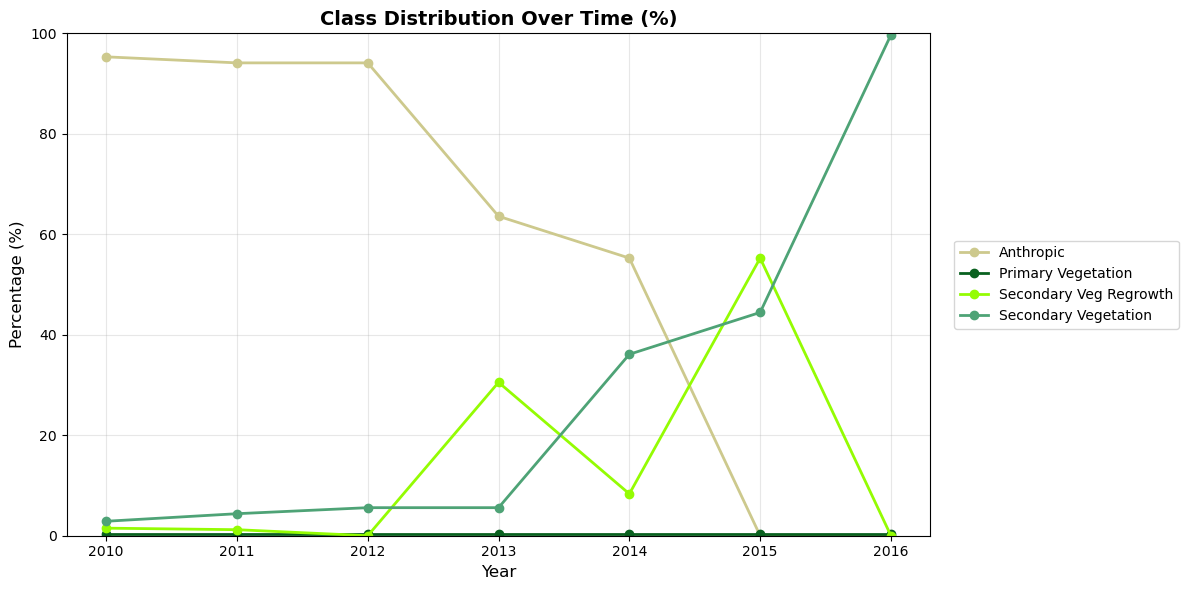

In [17]:
# Line chart: Class distribution over time (%)
# Pass the layer to automatically use MapBiomas DEFREG colors
fig, ax = plot_class_distribution(df, layer=MAPBIOMAS_DEFREG)
plt.show()

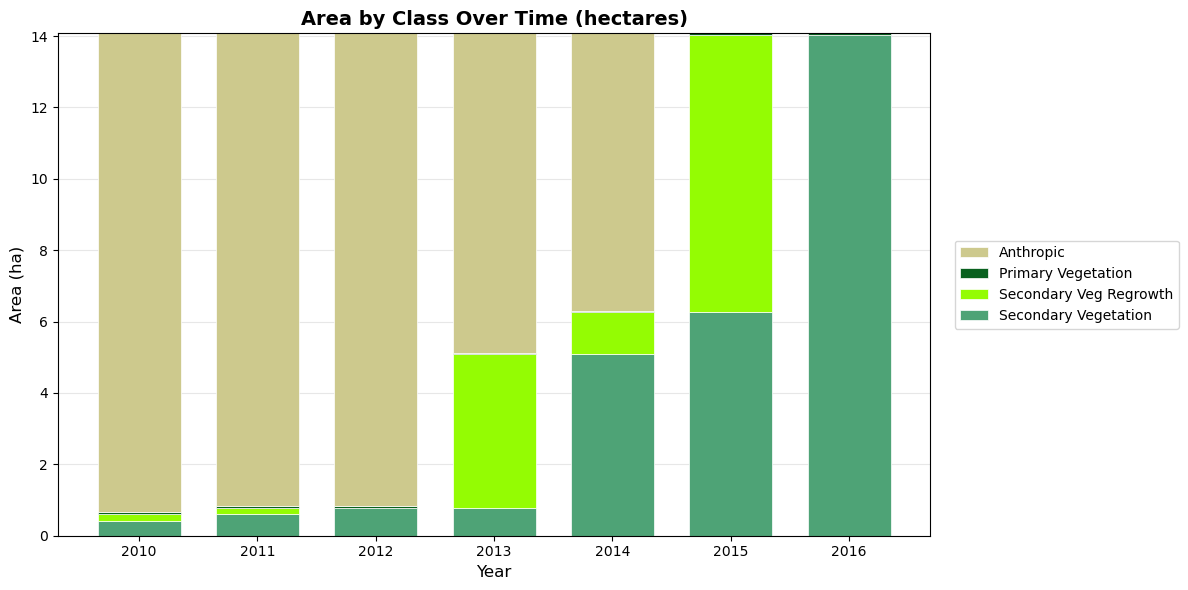

In [18]:
# Stacked bar chart: Area by class over time
fig, ax = plot_class_area_stacked(df, layer=MAPBIOMAS_DEFREG)
plt.show()

### Interactive Charts (Plotly)

In [19]:
# Interactive line chart
fig = plot_class_distribution_interactive(df, layer=MAPBIOMAS_DEFREG)
fig.show()

In [20]:
# Interactive stacked bar chart
fig = plot_class_area_stacked_interactive(df, layer=MAPBIOMAS_DEFREG)
fig.show()

### Using the Convenience Function

In [21]:
# Quick way to generate any chart type
# The layer parameter provides automatic coloring
plot_extraction(df, chart_type='distribution', interactive=True, layer=MAPBIOMAS_DEFREG)

### Aggregated Charts

Combine multiple classes into a single metric while showing components:

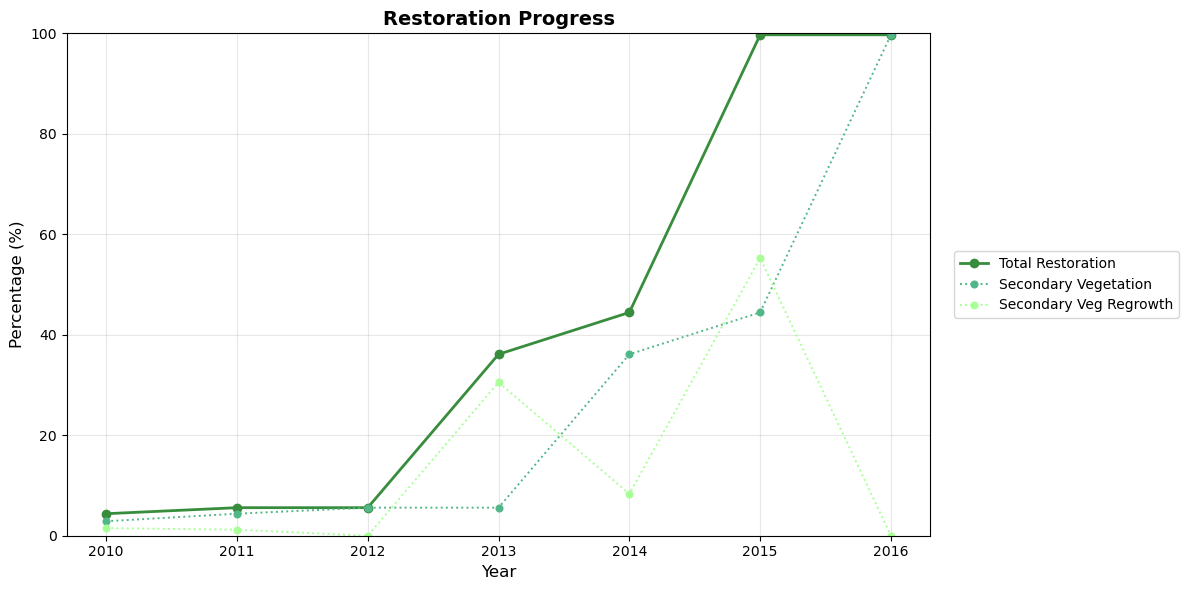

In [25]:
# Define aggregates: which classes combine into which totals
aggregates = {
    'Total Restoration': ['Secondary Vegetation', 'Secondary Veg Regrowth']
}

# Custom colors: green shades for the restoration theme
restoration_colors = {
    'Total Restoration': "#388d3d",      # dark green for total
    'Secondary Vegetation': '#52b788',   # medium green
    'Secondary Veg Regrowth': "#a9ff97", # light green
}

fig, ax = plot_aggregated(
    df,
    aggregates=aggregates,
    colors=restoration_colors,
    title='Restoration Progress'
)
plt.show()

In [26]:
# Interactive version
fig = plot_aggregated_interactive(
    df,
    aggregates=aggregates,
    colors=restoration_colors,
    title='Restoration Progress'
)
fig.show()

In [24]:
#| hide
import nbdev; nbdev.nbdev_export()